<a href="https://colab.research.google.com/github/zzerross/ai/blob/main/rnn/sin/LSTMSinReference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Refer https://m.blog.naver.com/chunjein/222131850058
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
# 1차원 배열의 시계열 데이터로 학습용 배치 파일을 만든다. 입력값 = 1개, 출력값 = 1개
# return : xBatch - RNN 입력
#          yBatch - RNN 출력
#
# step = 3 인 경우의 예시
# xData = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
# 
# xBatch, yBatch는 3차원 텐서로 만든다. (-1, step=3, 1)
# xBatch = [[1]] [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] --> 7 x 3 x 1
#          [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] [[8]]
#          [[3]] [[4]] [[5]] [[6]] [[7]] [[8]] [[9]]
#
# yBatch =  [4]   [5]   [6]   [7]   [8]   [9]   [10] --> 7 x 1
#
# ex : xBatch[0] = [[3],[4],[5]],   yBatch[0] = [6]
#      3-step 짜리 LSTM에 3,4,5가 입력되면 6이 출력되도록 학습한다.
def createTrainData(xData, step):
    m = np.arange(len(xData) - step)
    x, y = [], []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    xBatch = np.reshape(np.array(x), (len(m), step, 1))
    for i in m+1:
        a = xData[i:(i+step)]
        y.append(a[-1])
    yBatch = np.reshape(np.array(y), (len(m), 1))
    return xBatch, yBatch

def make_sequence(input, timesteps):
  x = list(map(lambda x: input[x:x+timesteps], range(len(input) - timesteps)))
  y = input[timesteps:]
  return np.reshape(x, (-1, timesteps, 1)), np.reshape(y, (-1, 1))

def get_input(start, end, num):
  radians = np.linspace(start, end, num)
  sin = np.sin(radians) + np.random.random(num)
  return radians, sin

# 시계열 데이터 (noisy sin)
n = 1000 + 1
# original:
# radians = 2 * np.pi * 0.03 * np.arange(1001)
# data = np.sin(radians) + np.random.random(n) # trend & noisy sine
radians = 0.5 * np.arange(n)
data = get_input(-10, 10, n)[1]

nInput = 1
nOutput = 1
nStep = 20
nHidden = 50
# 학습 데이터를 생성한다.
# original
x, y = createTrainData(data[-800:], nStep)
train_x, train_y = make_sequence(data[-800:], nStep)
test_x, test_y = make_sequence(data[:-200:], nStep)

In [ ]:
# LSTM 모델을 생성한다.
xInput = Input(batch_shape=(None, nStep, 1))
xLstm = LSTM(nHidden)(xInput)
xOutput = Dense(nOutput)(xLstm)
model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
# 학습한다
h = model.fit(train_x, train_y, epochs=100, batch_size=100, shuffle=True, verbose=0)

In [ ]:
predicted_y = model.predict(test_x)

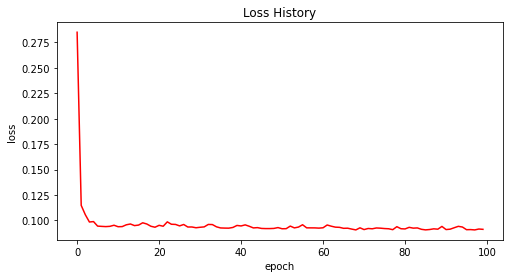

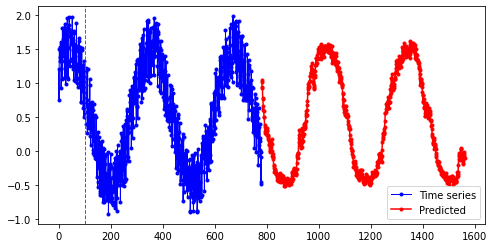

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 4))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(predicted_y))
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(train_y)), train_y, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(np.arange(len(train_y), len(train_y) + len(predicted_y)), predicted_y, 'b-o', color='red', markersize=3, label='Predicted')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()